# Supervised/unsupervised Sentiment and Topic analysis. <br>

### Final project assignment. <br>

Introduction  to Natural Language Processing (NLP) 
(DSCI-D590-31731)

Anitha Ganapathy | aganapa@iu.edu <br>
12/01/2020

In [1]:
!nvidia-smi

Sat Dec 12 05:54:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [149]:
# !nvcc --version

In [ ]:
# !pip install docx2txt
# !pip install tensorflow_text


Organizing imports.

In [50]:
import nltk
import os
import sys
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import docx2txt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import seaborn as sns
import gensim
import json
import datetime

from tqdm import tqdm
from nltk import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import wordnet
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import text, sequence
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from gensim.models import word2vec
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

# plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 2000737430
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [7]:
print(os.listdir("../content"))
print(f'Python version     : {sys.version}')
print(f'Pandas version     : {pd.__version__}')
print(f'Numpy version      : {np.__version__}')
print(f'Tensorflow version : {tf.__version__}')
print(f'NLTK version       : {nltk.__version__}')
print(f'Regex version      : {re.__version__}')
print("GPU Device name: ",tf.config.list_physical_devices('GPU'))
# print("\nCheck if GPU is available: ", tf.test.is_gpu_available())

['.config', 'Amazon Fine Food Reviews.csv', 'sample_data']
Python version     : 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
Pandas version     : 1.1.5
Numpy version      : 1.18.5
Tensorflow version : 2.3.0
NLTK version       : 3.2.5
Regex version      : 2.2.1
GPU Device name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Dataset**
The data I am using for the assignment is the Amazon Fine Food Reviews. <br>
https://www.kaggle.com/snap/amazon-fine-food-reviews
 

**Data Reference:**

J. McAuley and J. Leskovec. From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews. WWW, 2013.

In [150]:
df = pd.read_csv("Amazon Fine Food Reviews.csv", parse_dates= True)

## Step 1 :  Describe data.

In [151]:
print("The Amazon Fine Food Reviews dataset brief:")
print("\nNumber of reviews:", df.shape[0])
print("Number of users: ", len(df.UserId.unique()))
print("Number of products: ", len(df.ProductId.unique()) )
print("Number of Attributes/Columns in data: ", len(df.columns))

The Amazon Fine Food Reviews dataset brief:

Number of reviews: 568454
Number of users:  256059
Number of products:  74258
Number of Attributes/Columns in data:  10


In [152]:
# df.head()

The column or features in the dataset: <br>
*   Id <br>
*   ProductId — unique identifier for the product <br>
*   UserId — unqiue identifier for the user
*   ProfileName <br>
*   HelpfulnessNumerator — number of users who found the review helpful <br>
*   HelpfulnessDenominator — number of users who indicated whether they found the review helpful or not <br>
*   Score — rating between 1 and 5 <br>
*   Time — timestamp for the review <br>
*   Summary — brief summary of the review <br>
*   Text — text of the review <br>







In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [12]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


Checking for NAN values in the dataset. Nan values in the text column provided difficulty in plotting the wordcloud.
So replaced the nan with empty string.


In [13]:
df.isna().sum()             

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

## Step 2: Perform data preprocessing.

In [14]:
#df = pd.read_csv("Amazon Fine Food Reviews.csv", parse_dates= True)

df_old = df
df.Summary = df.Summary.fillna('')       # replacing the NAN with ''
df['review'] = df['Summary'] + df['Text']
df.isna().sum()    

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    0
Text                       0
review                     0
dtype: int64

In [15]:
df = df[['Score', 'review']]
df.head()

,Score,review
0,5,Good Quality Dog FoodI have bought several of ...
1,1,Not as AdvertisedProduct arrived labeled as Ju...
2,4,"""Delight"" says it allThis is a confection that..."
3,2,Cough MedicineIf you are looking for the secre...
4,5,Great taffyGreat taffy at a great price. Ther...


In [16]:
df.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [17]:
df.isna().sum()    

Score     0
review    0
dtype: int64

### Analysing the data. 

Text(0.5, 1.0, 'Amazon Food and Wine Reviews.')

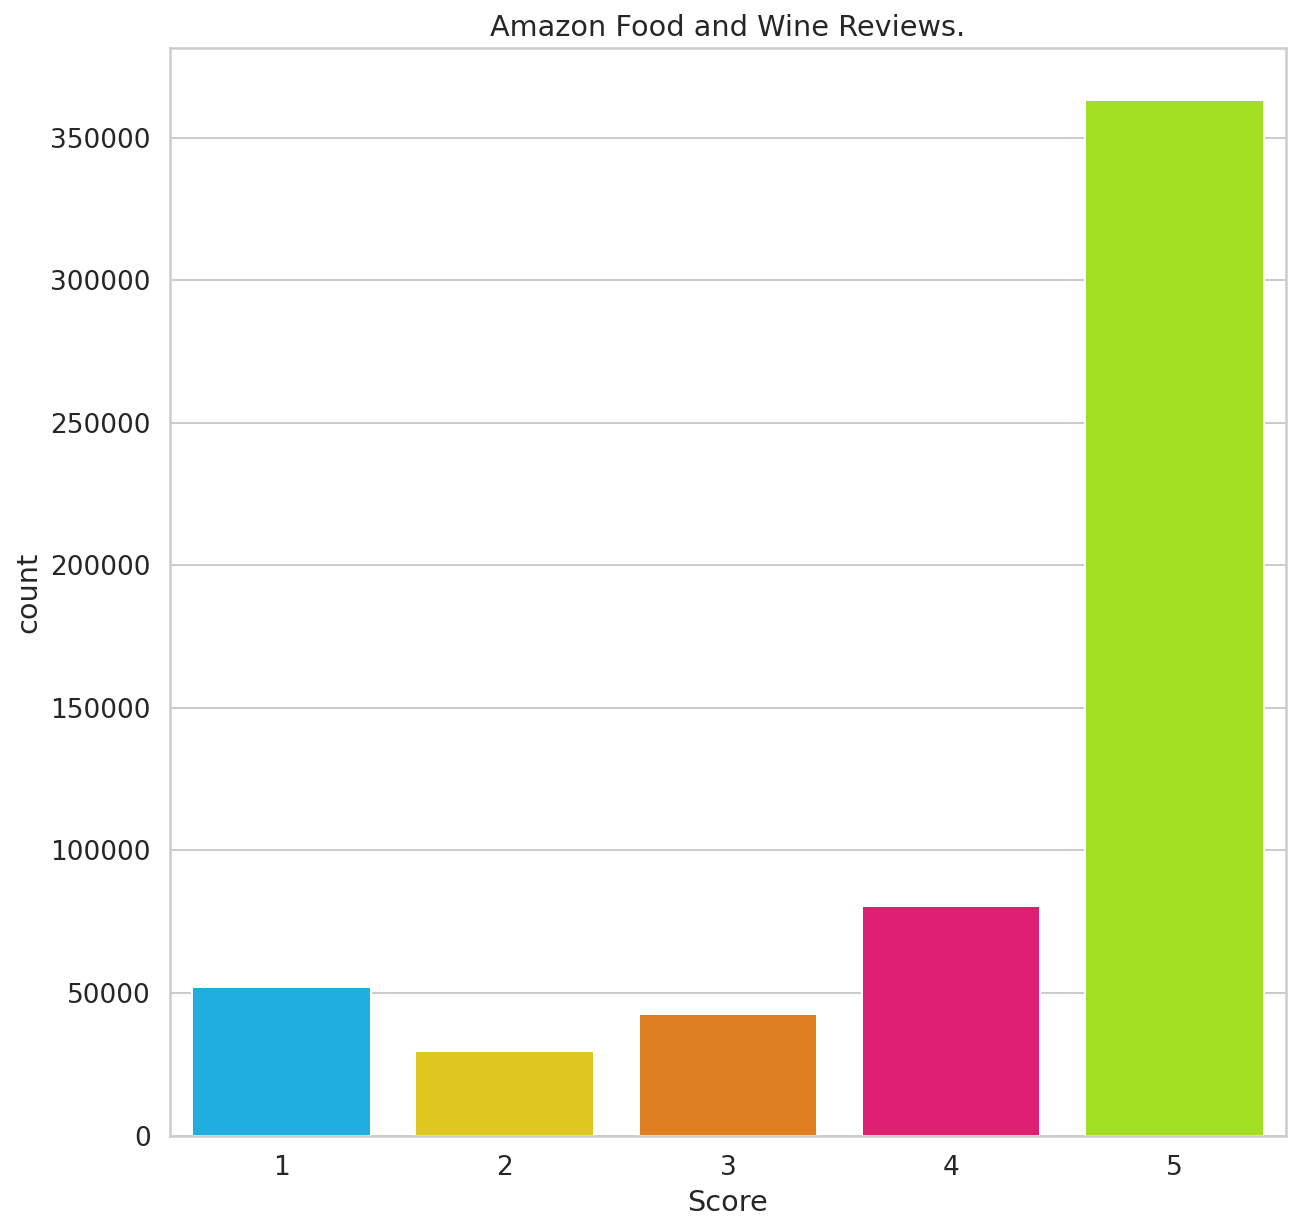

In [18]:
# sns.countplot(df['Score'], order=df.Score.value_counts().index)
sns.countplot(df['Score'])
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Amazon Food and Wine Reviews.')

Just for simplicity and because we need more data for the binary classification of Good or Bad reviews, we shall consider a rating of 3 or less as bad reviews and a rating of 4 and more as good reviews

In [19]:
# Give reviews with Score > 3 a positive rating('good), 
# and reviews with a score<=3 a negative review_type('bad').

df["review_type"] = df["Score"].apply(lambda x: "negative" if x <= 3 else "positive")

In [20]:
df.review_type.value_counts()

positive    443777
negative    124677
Name: review_type, dtype: int64

Text(0.5, 1.0, 'Review type')

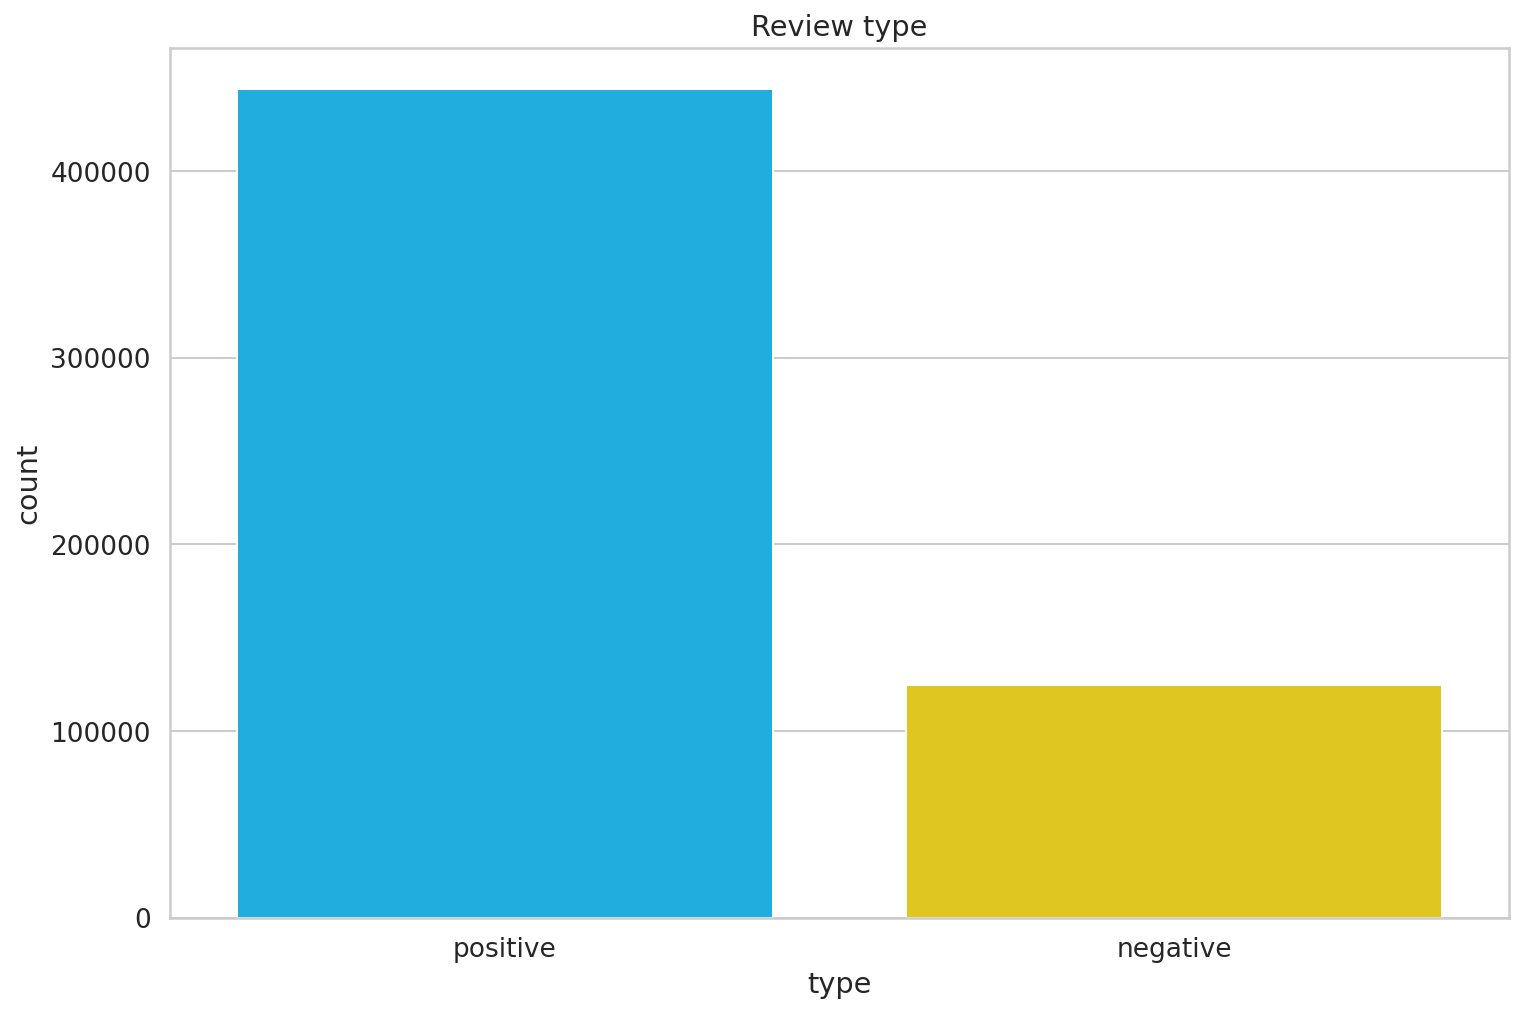

In [21]:
sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)
plt.xlabel("type")
plt.title("Review type")

In [22]:
positive_reviews = df[df.review_type == "positive"]
negative_reviews = df[df.review_type == "negative"]

print("Good reviews shape: ",positive_reviews.shape)
print("Bad reviews shape: ", negative_reviews.shape)

Good reviews shape:  (443777, 3)
Bad reviews shape:  (124677, 3)


We need the good and bad reviews to have same review counts, so we will take equal amout of good reviews as bad.

In [23]:
positive_reviews_text = " ".join(positive_reviews.review.to_numpy().tolist())
negative_reviews_text = " ".join(negative_reviews.review.to_numpy().tolist())


In [31]:
from nltk.corpus import stopwords
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    # lowercase and remove special characters\whitespace
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, flags =re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
  


In [25]:
positive_normalize_text = normalize_document(positive_reviews_text)
negative_normalize_text = normalize_document(negative_reviews_text)


In [26]:
datetime.datetime.now()
positive_reviews_cloud = WordCloud(stopwords=STOPWORDS,background_color="black").generate(positive_normalize_text)
negative_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(negative_normalize_text)
datetime.datetime.now()

In [33]:
print(datetime.datetime.now())
def show_word_cloud(cloud, title):
  plt.figure(figsize = (20, 20))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show()
print(datetime.datetime.now())

2020-12-12 06:02:10.231269
2020-12-12 06:02:10.231701


## Step 3: Topic Analysis

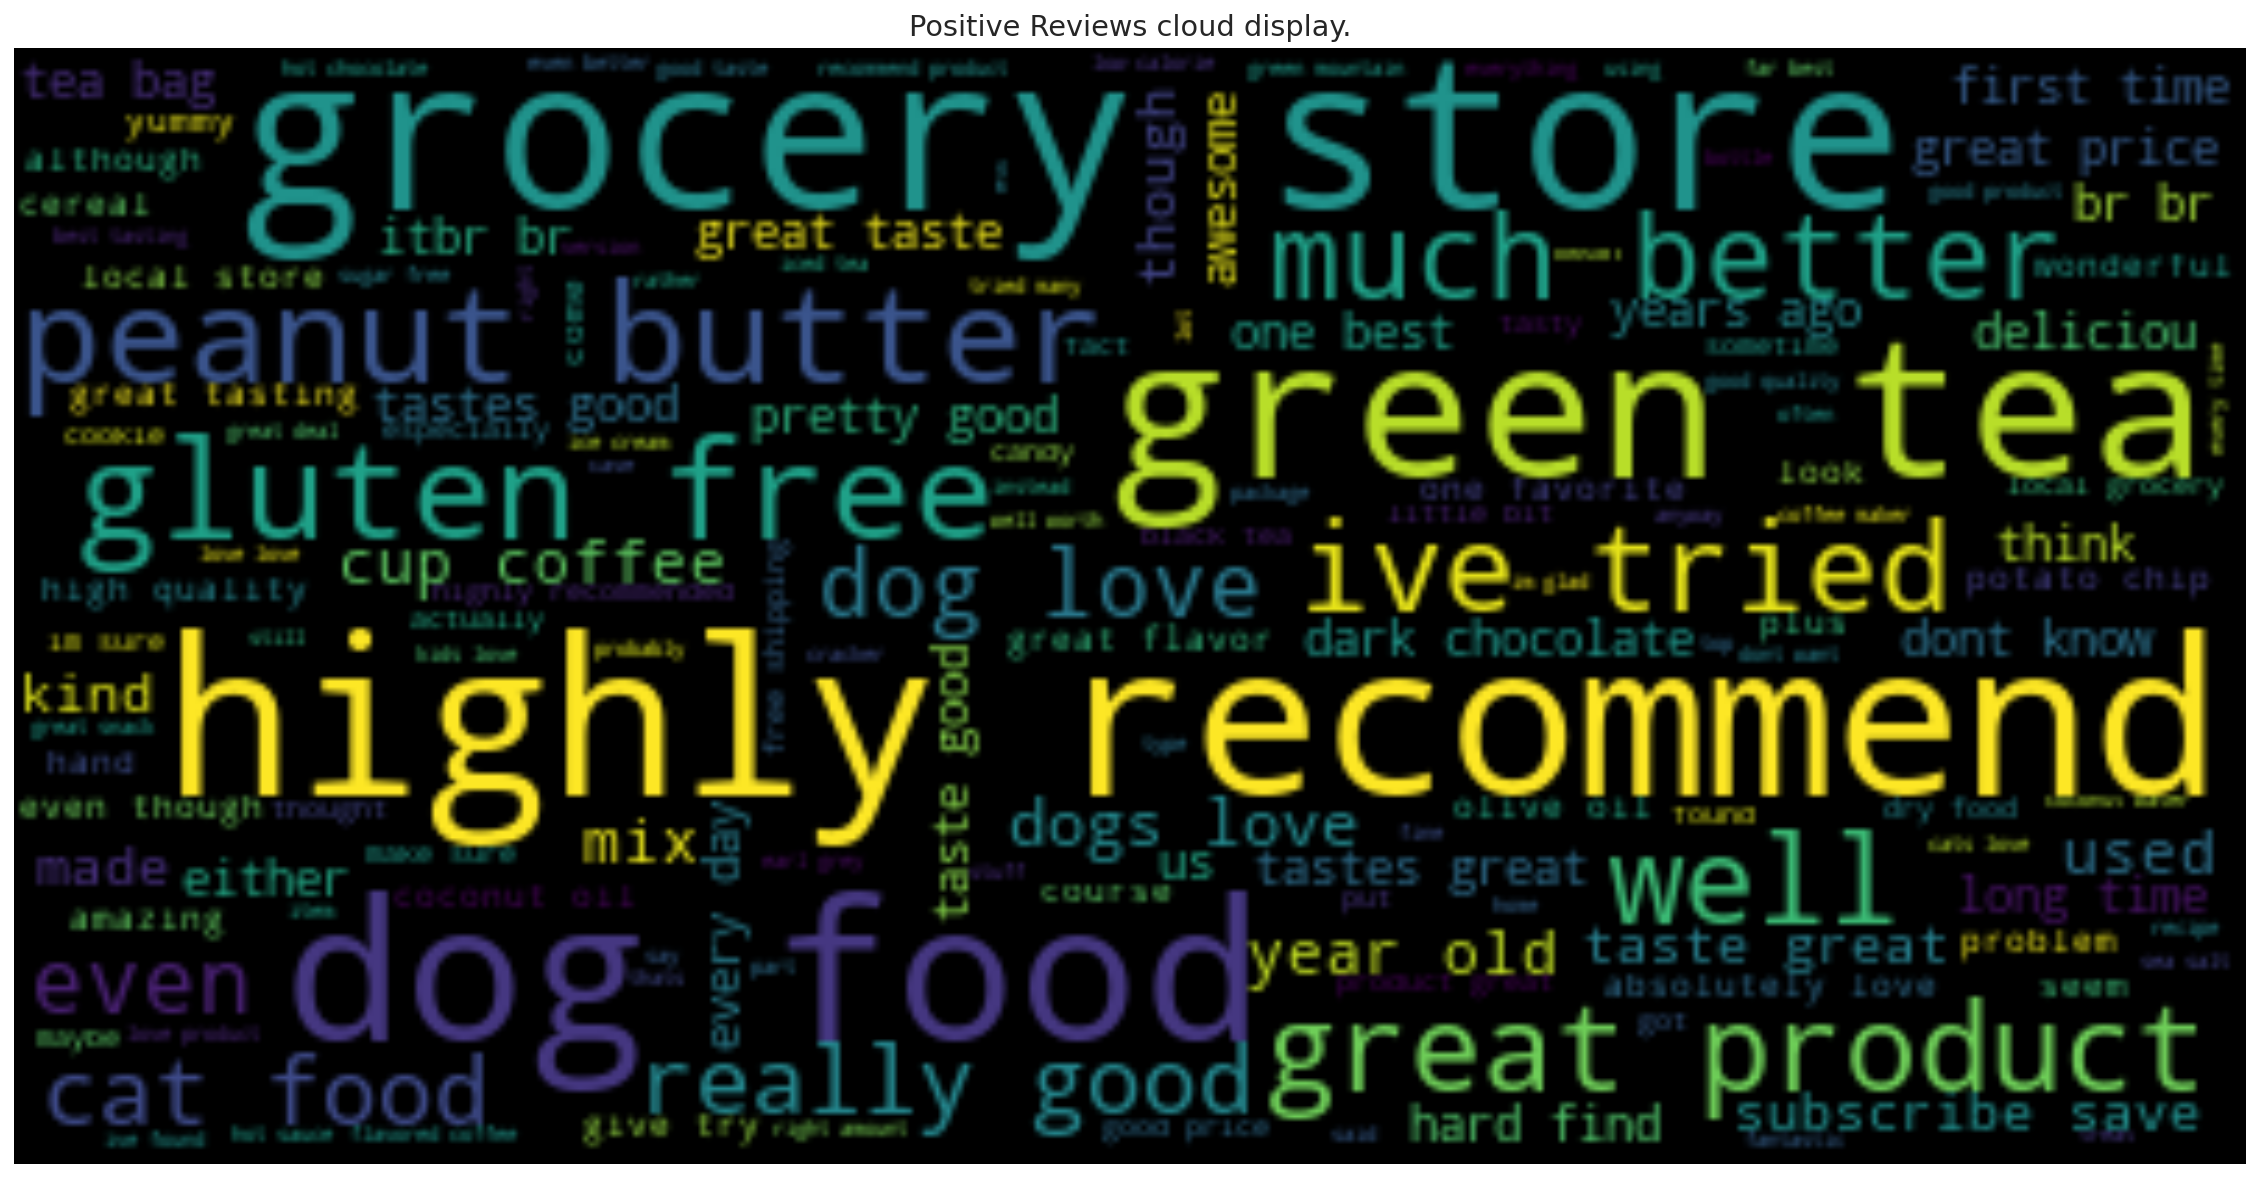

In [34]:
show_word_cloud(positive_reviews_cloud, "Positive Reviews cloud display.")

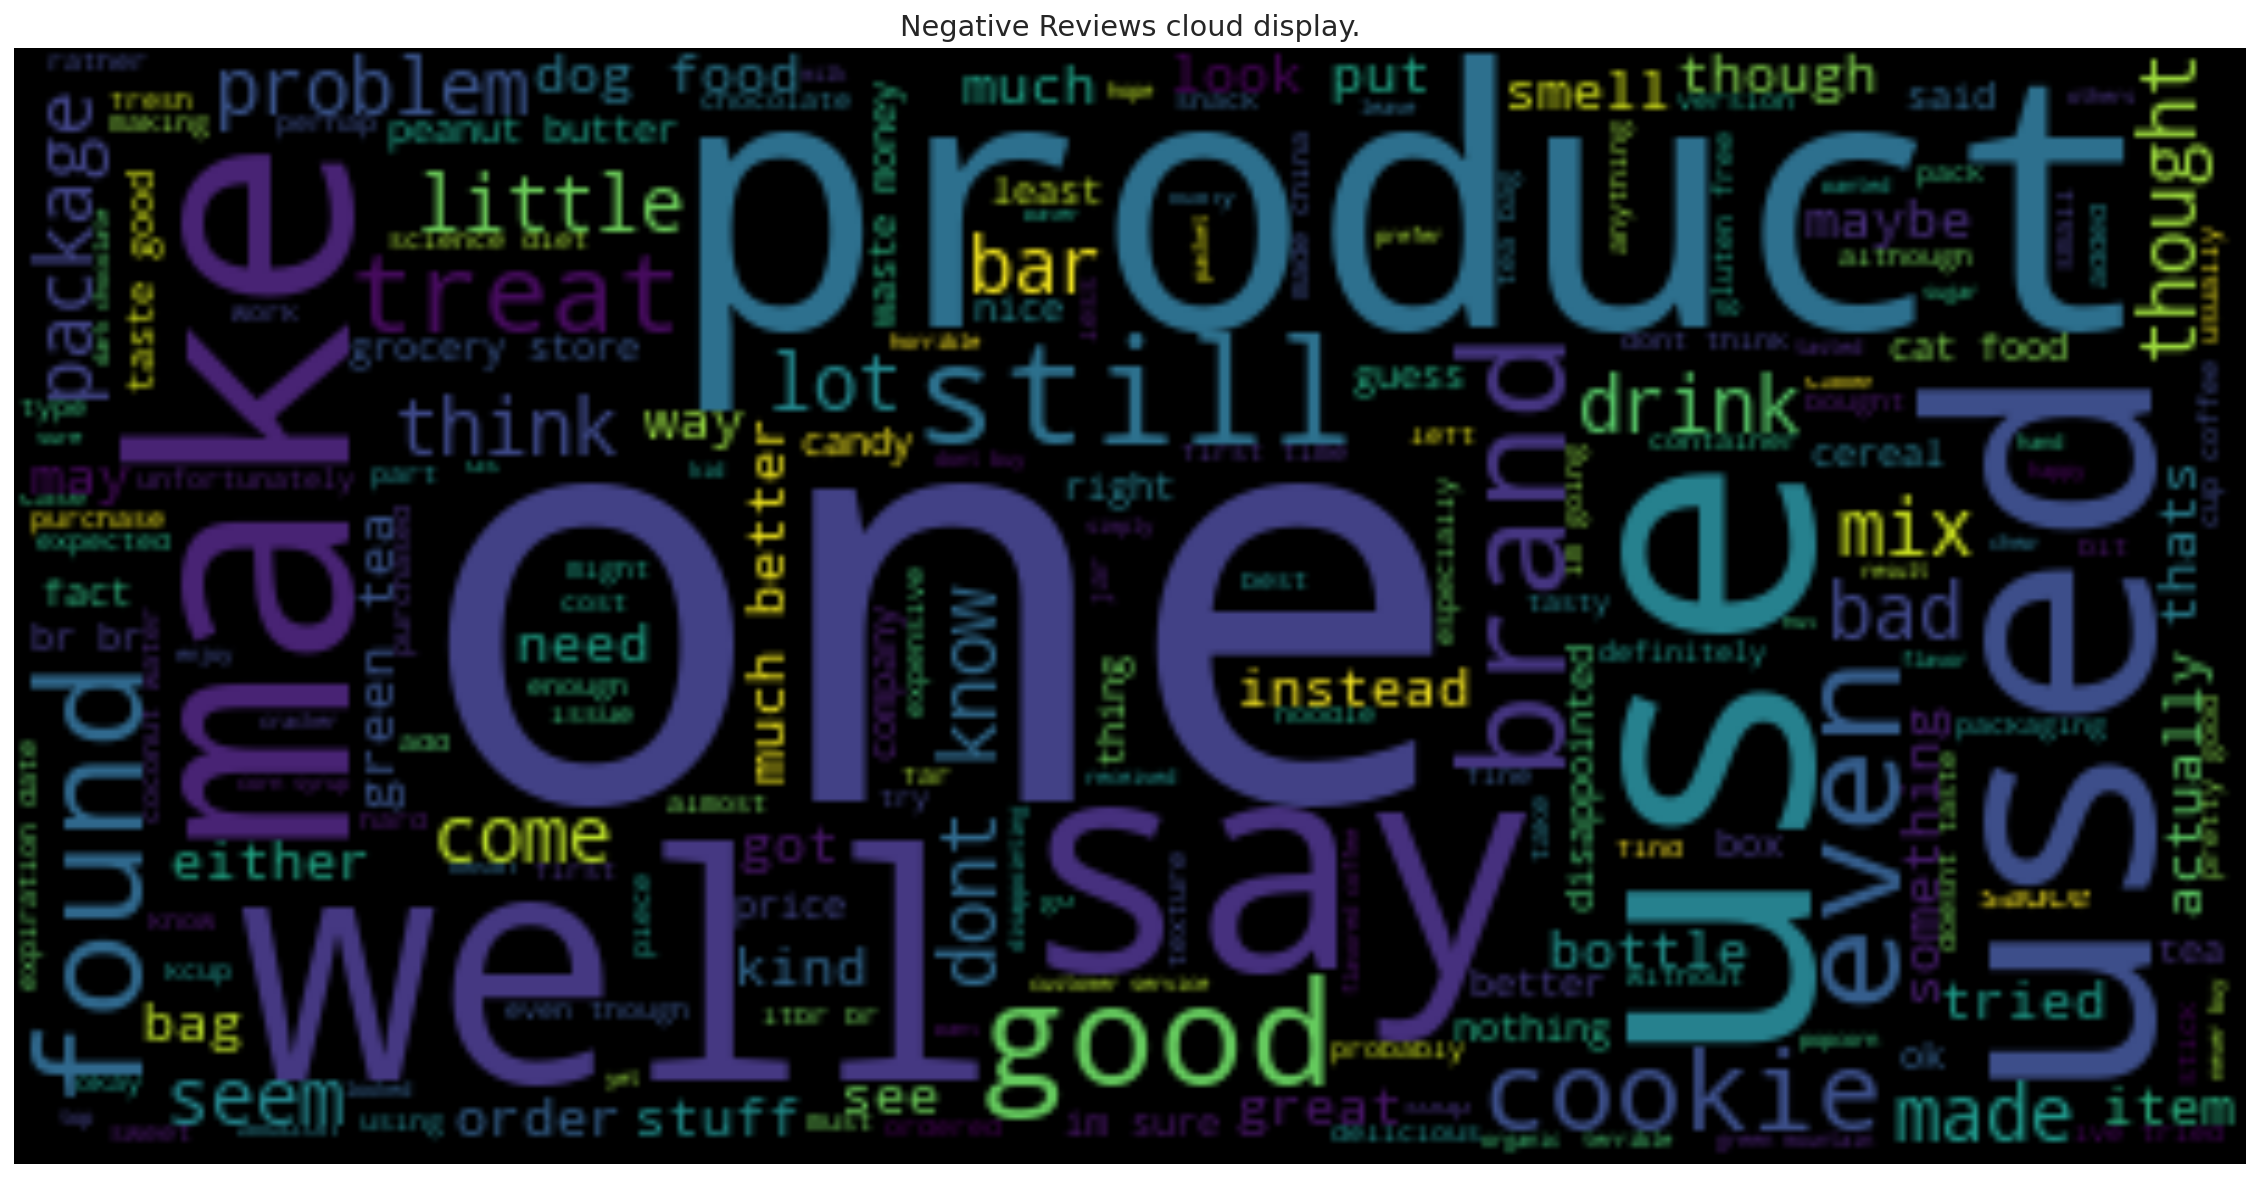

In [35]:
show_word_cloud(negative_reviews_cloud, "Negative Reviews cloud display.")

We’ll deal with the review type count imbalance by sampling the number of good ones to that of the bad ones. We need same amount of positive and negative reviews.

In [36]:
positive_df = positive_reviews.sample(n=len(negative_reviews), random_state=RANDOM_SEED)
negative_df = negative_reviews

In [37]:
review_df = positive_df.append(negative_df).reset_index(drop=True)
print("Final review data df shape: ", review_df.shape)

Final review data df shape:  (249354, 3)


Text(0.5, 1.0, 'Review type (resampled)')

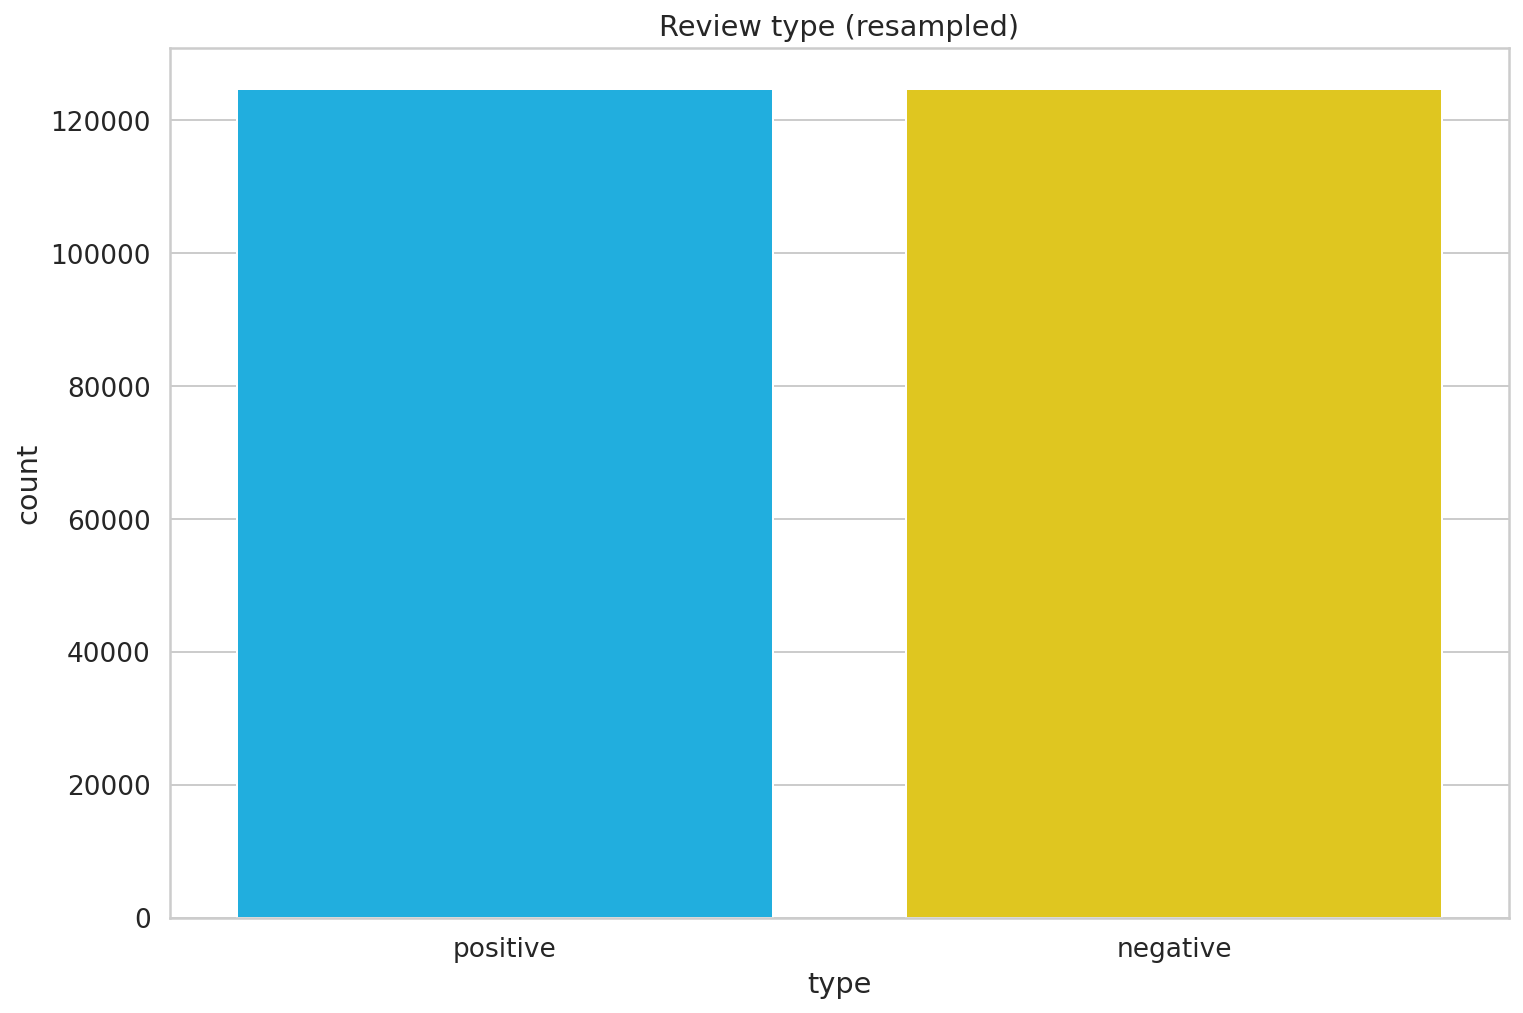

In [38]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)")

google/universal-sentence-encoder/4 - a much larger model yielding 512 dimensional embeddings trained with a deep averaging network (DAN) encoder.

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering, and other natural language tasks.



In [39]:
import tensorflow_hub as hub

# it took 14 mins to load this module

print(datetime.datetime.now())
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")
print(datetime.datetime.now())

2020-12-12 06:02:59.901877
2020-12-12 06:16:37.210808


In [40]:
sent_1 = ["the location is great"]
sent_2 = ["amazing location"]

emb_1 = use(sent_1)
emb_2 = use(sent_2)
emb_1.shape

TensorShape([1, 512])

In [41]:
np.inner(emb_1, emb_2).flatten()[0]

0.79254675

## Step 4. Splitting data into training and testing.
Split in 80-20 training or UseCross-validation

In [42]:
type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [43]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.2, 
    random_state=RANDOM_SEED
  )

## Step 5: Perform data vectorization.

In [45]:
print(datetime.datetime.now())
X_train = []
for r in tqdm(train_reviews):
  embedded = use(r)
  review_emb = tf.reshape(embedded, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)
print(datetime.datetime.now())

  0%|          | 5/199483 [00:00<1:14:57, 44.35it/s]

2020-12-12 06:20:09.520324


100%|██████████| 199483/199483 [51:58<00:00, 63.97it/s]


2020-12-12 07:12:08.403913


In [46]:
print(datetime.datetime.now())
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)
print(datetime.datetime.now())

  0%|          | 5/49871 [00:00<17:36, 47.19it/s]

2020-12-12 07:12:38.939502


100%|██████████| 49871/49871 [13:01<00:00, 63.82it/s]

2020-12-12 07:25:40.443657


In [47]:
print(X_train.shape, X_test.shape)

(199483, 512) (49871, 512)


In [113]:
print(y_train.shape, y_test.shape)

(199483, 2) (49871, 2)


## Step 6: Sentiment analysis

Sentiment Analysis is a binary classification problem. Let’s use Keras to build a model.

In [51]:
model = keras.Sequential()

model.add(keras.layers.Dense(units=256, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


The model is composed of 2 fully-connected hidden layers. Dropout is used for regularization.

We’ll train for 15 epochs and use 10% of the data for validation:

In [52]:
print(datetime.datetime.now())

history = model.fit(
    X_train, y_train, 
    epochs=15, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

print(datetime.datetime.now())

2020-12-12 07:30:47.334659
Epoch 1/15
11221/11221 [==============================] - 29s 3ms/step - loss: 0.3054 - accuracy: 0.8712 - val_loss: 0.2833 - val_accuracy: 0.8795
Epoch 2/15
11221/11221 [==============================] - 31s 3ms/step - loss: 0.2737 - accuracy: 0.8865 - val_loss: 0.2684 - val_accuracy: 0.8897
Epoch 3/15
11221/11221 [==============================] - 31s 3ms/step - loss: 0.2534 - accuracy: 0.8968 - val_loss: 0.2703 - val_accuracy: 0.8878
Epoch 4/15
11221/11221 [==============================] - 31s 3ms/step - loss: 0.2350 - accuracy: 0.9041 - val_loss: 0.2513 - val_accuracy: 0.8980
Epoch 5/15
11221/11221 [==============================] - 31s 3ms/step - loss: 0.2204 - accuracy: 0.9106 - val_loss: 0.2487 - val_accuracy: 0.8996
Epoch 6/15
11221/11221 [==============================] - 29s 3ms/step - loss: 0.2057 - accuracy: 0.9172 - val_loss: 0.2555 - val_accuracy: 0.9024
Epoch 7/15
11221/11221 [==============================] - 30s 3ms/step - loss: 0.1939 - acc

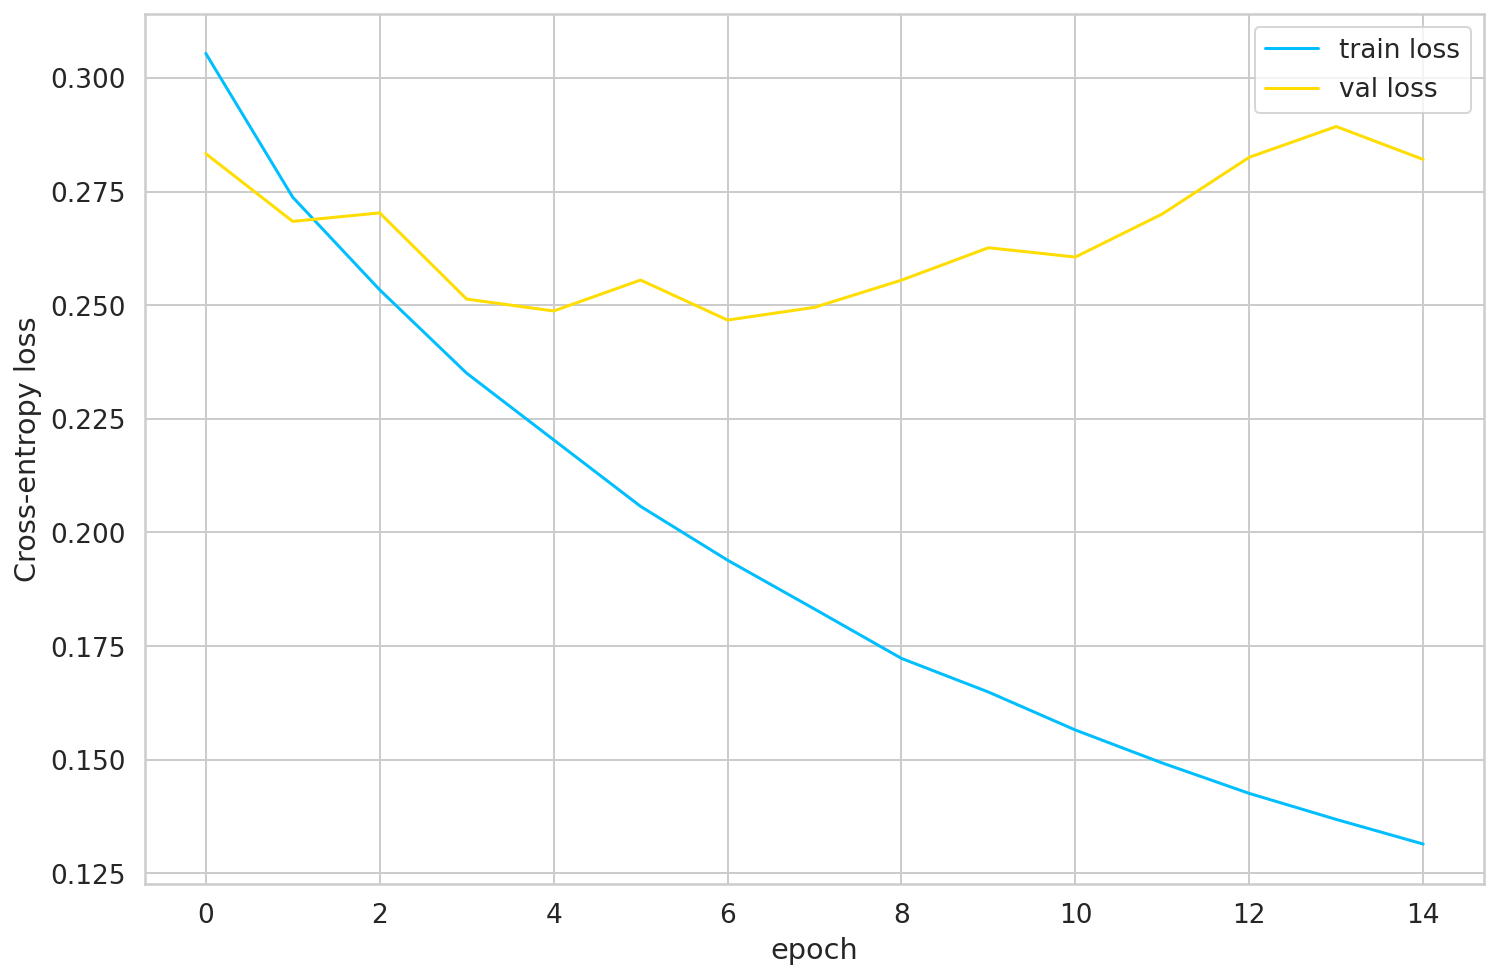

In [64]:
rcParams['figure.figsize'] = 12, 8
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

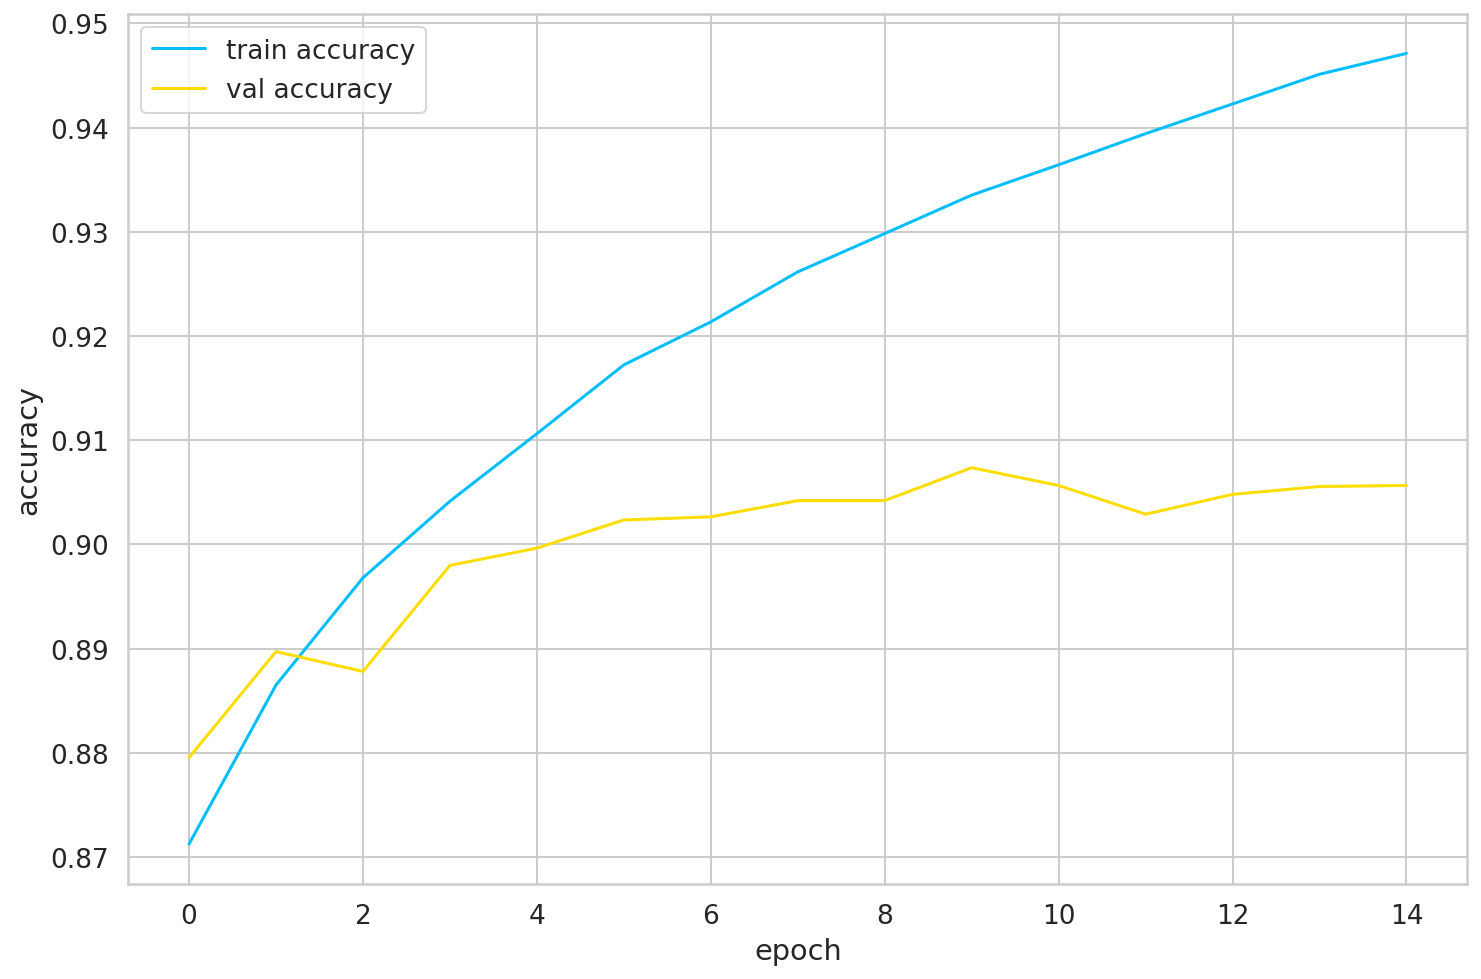

In [65]:
rcParams['figure.figsize'] = 12, 8
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [92]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9047
Testing Accuracy:  0.9047


Testing Accuracy:  0.9047


## Step 7: Predicting Sentiment

Example : 1

In [73]:
print(test_reviews.iloc[0])
print("Sentiment Analysis is :")
print("Bad" if y_test[0][0] == 1 else "Good")

O MY GOODNESSWhere has this butter been all my life!? I LOVE IT. It's like coconut flavored white chocolate. This over almond butter. TWO thumbs up!
Sentiment Analysis is :
Good


In [76]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[1.3080695e-05 9.9998689e-01]]


'Good'

Example 2:

In [79]:
print(test_reviews.iloc[1])
print("Bad" if y_test[1][0] == 1 else "Good")


these are actually awfuli gave it 2 stars because i was able to swallow 2 spoonfuls. so bad, the 3rd spoonful i gagged. so bad, i googled the name to write an amazon review. so bad, im going to put it outside for the stray cats because my mom would kill me if she knew i wasted food.
Bad


In [80]:
y_pred = model.predict(X_test[1:2])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[9.999907e-01 9.355102e-06]]


'Bad'

Example 3:

In [82]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5][0] == 1 else "Good")

Change in blend?I am a long time lover of Caffe Verona whole beans.  However, I bought a bag two days ago and noticed that the bag design is new, and in addition the most prominent word on the front of the bag reads "DARK", unlike the prior design with the word "BOLD" being less prominent.  This would not be worthy of comment if the product tasted the same as Caffe Verona Bold.  After grinding for three mornings I am convinced that the formula or process has been changed.  If this one bag is not an anomaly, Caffe Verona is no longer my favorite--same for other family members who are also discerning coffee lovers.
Bad


In [83]:
y_pred = model.predict(X_test[5:6])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.99064845 0.00935157]]


'Bad'

## Step 8: Confusion matrix

In [146]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

labels=['positive','negative']

#Confusion Matrix and Classification Report
#confusion matrix
y_pred=model.predict(X_test)
#y_pred = (y_pred > 0.5)

#cm =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#print("Confusion Matrix : \n", cm)

In [145]:
confusion_df = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)),
             columns=["Predicted Class " + str(class_name) for class_name in [0,1]],
             index = ["Class " + str(class_name) for class_name in [0,1]])

print(confusion_df)

         Predicted Class 0  Predicted Class 1
Class 0              22641               2282
Class 1               2469              22479


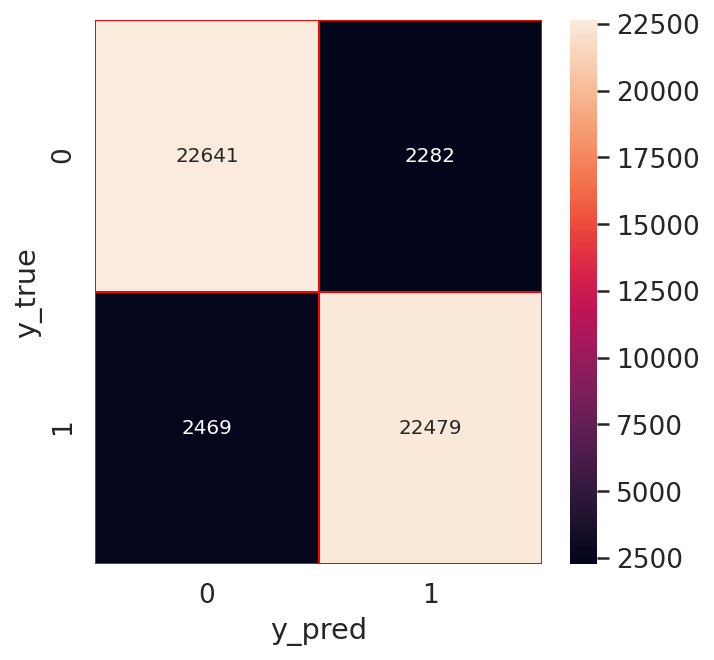

In [148]:
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Step 9: Classification Report.

Precision Score <br>
TP – True Positives <br>
FP – False Positives<br>

Precision – Accuracy of positive predictions. <br>
Precision = TP/(TP + FP)<br>

In [128]:
from sklearn.metrics import precision_score

print("Precision score: {}".format(precision_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))))

Precision score: 0.9078389402689714


Recall Score <br>
FN – False Negatives <br>

Recall (aka sensitivity or true positive rate): <br>
Fraction of positives That were correctly identified. <br>
Recall = TP/(TP+FN) <br> 



In [130]:
from sklearn.metrics import recall_score

print("Recall score: {}".format(recall_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))))

Recall score: 0.9010341510341511


F1 Score <br>
F1 Score (aka F-Score or F-Measure) – A helpful metric for comparing two classifiers. F1 Score takes into account precision and the recall. It is created by finding the the harmonic mean of precision and recall.
<br>
F1 = 2 x (precision x recall)/(precision + recall)

In [134]:
from sklearn.metrics import f1_score

print("F1 Score: {}".format(f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))))

F1 Score: 0.9044237462029008


#### Classification Report
Report which includes Precision, Recall and F1-Score.

In [143]:
print("CLASSIFICATION REPORT: \n")
cr = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cr)

CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     24923
           1       0.91      0.90      0.90     24948

    accuracy                           0.90     49871
   macro avg       0.90      0.90      0.90     49871
weighted avg       0.90      0.90      0.90     49871



## Step 10: Conclusion


1.   We started with analyzing and describing the data and providing a few metrics.
2.   We then proceeded with data preprocessing and creating the word clouds for the positive and negative reviews.
3.   We used the USE for word embeddings and tested our data with the Keras model.
4.   We achieved an accuracy of 91% and 90% for the negative and positive reviews respectively.
5.   The full confusion matrix and the classification reports are detailed as above.
6.  We also checked few test data as well.





## Step 11: Reference:

https://curiousily.com/posts/sentiment-analysis-with-tensorflow-2-and-keras-using-python/

https://realpython.com/python-keras-text-classification/


https://joshlawman.com/metrics-classification-report-breakdown-precision-recall-f1/

# Step 12: The END